In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
import pickle
import kaggle

In [2]:
# Loading in dataset using kaggle api
kaggle.api.dataset_download_file('harishkumardatalab/housing-price-prediction', 'housing.csv')

df = pd.read_csv('housing.csv')
print(df.head())
df.info()

      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 colu

In [3]:
df.shape

(545, 13)

In [4]:
# extracting features and labels
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [5]:
# Encoding the binary string inputs (yer or no)
binary_categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
label_encoder = LabelEncoder()
for feature in binary_categorical_features:
    X[feature] = label_encoder.fit_transform(X[feature])

# Encoding the furnishingstatus feature (furnished, semi-furnished, or unfurnished)
three_categorical_feature = 'furnishingstatus'
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
furnishingstatus_encoded = onehot_encoder.fit_transform(X[[three_categorical_feature]])
furnishingstatus_encoded_df = pd.DataFrame(furnishingstatus_encoded, columns=onehot_encoder.get_feature_names_out([three_categorical_feature]))
X = pd.concat([X.drop(three_categorical_feature, axis=1), furnishingstatus_encoded_df], axis=1)

/Users/rohansrivastava/miniconda3/envs/ml_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
# Splittin data into train, val, and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [34]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [63]:
# Model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))  # Single output neuron for regression

In [64]:
# Compiling model
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 64)                960       
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dropout_14 (Dropout)        (None, 32)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 3073 (12.00 KB)
Trainable params: 3073 (12.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
# Training (early stopping for val loss stall)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1500, batch_size=8, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/1500
48/48 [==============================] - 0s 1ms/step - loss: 25822064803840.0000 - val_loss: 27060953153536.0000
Epoch 2/1500
48/48 [==============================] - 0s 803us/step - loss: 25822024957952.0000 - val_loss: 27060890238976.0000
Epoch 3/1500
48/48 [==============================] - 0s 758us/step - loss: 25821926391808.0000 - val_loss: 27060745535488.0000
Epoch 4/1500
48/48 [==============================] - 0s 714us/step - loss: 25821712482304.0000 - val_loss: 27060451934208.0000
Epoch 5/1500
48/48 [==============================] - 0s 697us/step - loss: 25821343383552.0000 - val_loss: 27059925549056.0000
Epoch 6/1500
48/48 [==============================] - 0s 719us/step - loss: 25820720529408.0000 - val_loss: 27059095076864.0000
Epoch 7/1500
48/48 [==============================] - 0s 711us/step - loss: 25819768422400.0000 - val_loss: 27057849368576.0000
Epoch 8/1500
48/48 [==============================] - 0s 702us/step - loss: 25818287833088.0000 - val_loss

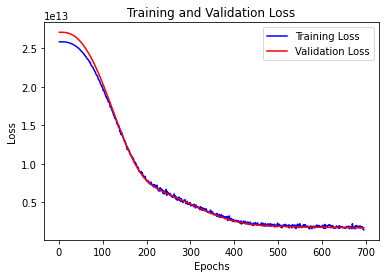

In [67]:
# Plotting losses
epochs = range(1, len(history.history['loss']) + 1)

plt.plot(epochs, history.history['loss'], 'b', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [68]:
# Testing model
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")

3/3 [==============================] - 0s 1ms/step - loss: 1354767532032.0000
Test Loss: 1354767532032.0


In [69]:
# Calculating mse
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

3/3 [==============================] - 0s 790us/step
Mean Squared Error: 1354767404387.2349


3/3 [==============================] - 0s 875us/step


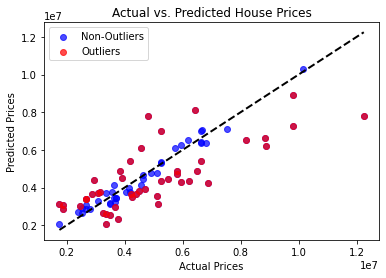

In [71]:
# Plotting prdictions vs. truth, housing prices are difficult lol
predictions = model.predict(X_test)

errors = np.abs(predictions.flatten() - y_test)
threshold = 500000
outlier_indices = np.where(errors > threshold)[0]

plt.scatter(y_test, predictions, c='b', label='Non-Outliers', alpha=0.7)  # Non-outliers are in blue
plt.scatter(y_test.iloc[outlier_indices], predictions[outlier_indices], c='r', label='Outliers', alpha=0.7)  # Outliers are in red
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Plot the line of best fit (y = x)

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted House Prices')
plt.legend()
plt.show()

In [72]:
# R2 score
r2 = r2_score(y_test, model.predict(X_test))
print(f"R-squared (R2) Score: {r2}")

3/3 [==============================] - 0s 837us/step
R-squared (R2) Score: 0.6844255038922091


In [74]:
# Saving model
model.save("models/r2_6844_model.h5")

# Saving model history
with open("model_histories/r2_6844_model_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

/Users/rohansrivastava/miniconda3/envs/ml_env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
